# When to use STACS
Although STACS can be used as a standalone spiking neural network simulator, it has also been integrated as a potential Fugu backend. It was developed for large-scale SNN simulations on HPC systems, but can also run multi-threaded on a single node (Linux, MacOS). It's operation is currently CPU-based, and it was designed on top of the Charm++ parallel programming system. More information about STACS can be found at its github page, https://github.com/sandialabs/STACS, which also includes some tutorials on installation and developing your own networks.

As a high-performance simulator, it can be beneficial to use STACS as a Fugu backend when network sizes are larger and the computational workload are higher. The way Fugu currently interfaces with STACS is through a file-based export from which STACS can compile the Fugu network into its own intermediate representation, and then executed through a Python subprocess. The STACS backend in Fugu is also responsible for reading back in the STACS output files and returning it into the Pandas dataframe that Fugu uses.

Because STACS must be installed separately on the same machine as Fugu, and this entails configuration and compilation of the Charm++ package from source, it can be difficult to get an environment properly set up. However, it is certainly worth the trouble for large-scale and long-running simulations. Fortunately, there should be no dependency conflicts between STACS and Fugu.

# How to use STACS
In the following example, we will implement a parameterized randomly sampled 80/20 network to demonstrate scaling. Before we begin though, the general overview of how to use STACS as a Fugu backend is below. There are a number of backend arguments that are relevant for a STACS simulation, which are generally dependent on the compute resources that are available. For this example, we assume single-node simulations.

```python
## Fugu import for STACS backend
from fugu.backends import stacs_Backend

## Develop Fugu Scaffold
scaffold = Scaffold()
# . . . define network . . .

## Generate the Fugu Graph
scaffold.lay_bricks()

## Set up Fugu-STACS backend
backend = stacs_Backend()
backend_args = {}
# set to true to print output from the STACS build process
backend_args['debug_mode'] = True
# ideally, this would be a list of the neuron indexes
# that have the 'record == True' attribute in Fugu
backend_args['record'] = 'all'
# location of charmrun and stacs executable
backend_args['stacsbin'] = '/home/felwang/stacs'
# location of where to save the network
backend_args['netwkdir'] = './fugunet'
# name of the network files
backend_args['filebase'] = 'fugunet'
# output format, default is Pandas dataframe, optionally event list
# one of the benefits of the event list is that it's easier to
# use matplotlib's eventplot to plot a spike raster with it
backend_args['format'] = 'dataframe' # 'eventlist'
# number of files to split the network across for storage
# 1 is probably fine for a single node machine, maybe 2
backend_args['npdat'] = 1
# number of partitions to split the network across
# if using just the default STACS build, this is equivalent to the number of cores
# if using a separate partitioner, it's better to set this to nprun for speed
backend_args['npnet'] = 8
# number of parallel processes to launch STACS with (e.g. num CPUs on the system)
# this number should be less than or equal to the number of partitions
backend_args['nprun'] = 8

## Compile with STACS backend
backend.compile(scaffold, backend_args)

## Run the network in STACS
# pass in number of timesteps
# returns fugu-formatted dataframe
fuguout_df = backend.run(1000)
```

In [1]:
## Imports
import numpy as np
import networkx as nx
import fugu
from fugu import Scaffold, Brick
from fugu.bricks import Vector_Input
from fugu.backends import snn_Backend, stacs_Backend
from fugu.scaffold import ChannelSpec, PortSpec, ChannelData, PortData, PortUtil

import yaml
import matplotlib
from matplotlib import pyplot as plt

import random
random.seed(0)

In [2]:
## Simple Network Brick
class sampled_8020_reservoir(Brick):
    """
    Randomly sampled 80/20 reservoir network
    felwang@sandia.gov
    """
    def __init__(self, name="sampled_8020_reservoir", num_reservoir=1000, num_readout=100,
                 syn_per_input=100, syn_per_reservoir=100, syn_per_readout=100):
        """
        Args:
            name (str): Name of the brick.  If not specified, a default will be used.  Name should be unique.
        """
        super(sampled_8020_reservoir, self).__init__(name)
        self.is_built = False
        self.name = name
        self.num_reservoir = num_reservoir
        self.num_readout = num_readout
        self.syn_per_input = syn_per_input
        self.syn_per_reservoir = syn_per_reservoir
        self.syn_per_readout = syn_per_readout

        # error checking the connectivity
        if self.syn_per_input > self.num_reservoir:
            print("warning: more connections than neurons, setting syn_per_input to num_reservoir")
            self.syn_per_input = self.num_reservoir
        if self.syn_per_reservoir > self.num_reservoir:
            print("warning: more connections than neurons, setting syn_per_reservoir to num_reservoir")
            self.syn_per_reservoir = self.num_reservoir
        if self.syn_per_readout > self.num_reservoir:
            print("warning: more connections than neurons, setting syn_per_readout to num_reservoir")
            self.syn_per_readout = self.num_reservoir

    @classmethod
    def input_ports(cls) -> dict[str, PortSpec]:
        port = PortSpec(name='input', minimum=1, maximum=1)
        port.channels['data']     = ChannelSpec(name='data', coding=['Raster'])
        port.channels['complete'] = ChannelSpec(name='complete')
        return {port.name: port}

    @classmethod
    def output_ports(cls) -> dict[str, PortSpec]:
        port = PortSpec(name='output')
        port.channels['data']     = ChannelSpec(name='data', coding=['Raster'])
        port.channels['complete'] = ChannelSpec(name='complete')
        return {port.name: port}
        
    def build2(self, graph, inputs: dict[str, PortData] = {}):
        """
        Build reservoir network
        """
        # Expect one input
        if len(inputs) != 1:
            raise ValueError('Only one input supported.')

        # Set up convenience variables for accessing our working ports.
        input1, = PortUtil.get_autoports(inputs, 'input', 1)  # Unpack the input ports.
        result = PortUtil.make_ports_from_specs(sampled_8020_reservoir.output_ports())  # Create our output port(s).
        output = result['output']  # Unpack the only actual output port.

        # Hook up the complete signals (doesn't really do much here)
        complete_node_name = self.generate_neuron_name('complete')
        output.channels['complete'].neurons = [complete_node_name]
        graph.add_node(complete_node_name, index=-1, threshold=1.0, decay=1.0, p=1.0, potential=0.0)
        graph.add_edge(input1.channels['complete'].neurons[0], complete_node_name, weight=2.0, delay=1.0)
        
        # Build the computational graph.
        # Input neurons
        input_neurons = input1.channels['data'].neurons
        # no need for additional work here, these are built in a different brick

        # Main network neurons
        # Split into 80/20
        num_ex = int(np.floor(self.num_reservoir * 0.8))
        num_in = self.num_reservoir - num_ex
        for n in range(num_ex):
            neuron_name = self.generate_neuron_name('reservoir'+str(n))
            graph.add_node(neuron_name, threshold=20.0, decay=0.1, p=1.0, potential=0.0)
        for n in range(num_ex, self.num_reservoir):
            neuron_name = self.generate_neuron_name('reservoir'+str(n))
            graph.add_node(neuron_name, threshold=20.0, decay=1.0, p=1.0, potential=0.0)
        
        # Output neurons
        readout_neurons = output.channels['data'].neurons
        for n in range(self.num_readout):
            readout_name = self.generate_neuron_name('readout'+str(n))
            graph.add_node(readout_name, threshold=40.0, decay=0.1, p=1.0, potential=0.0)
            readout_neurons.append(readout_name)
        
        # Connect inputs to reservoir
        for input_neuron in input_neurons:
            targets = random.sample(range(1, self.num_reservoir), self.syn_per_input)
            for t in targets:
                target_name = self.generate_neuron_name('reservoir'+str(t))
                graph.add_edge(input_neuron, target_name, weight=1.0, delay=1.0)

        # Connect reservoir to itself
        for n in range(num_ex):
            source_name = self.generate_neuron_name('reservoir'+str(n))
            targets = random.sample(range(1, self.num_reservoir), self.syn_per_reservoir)
            for t in targets:
                target_name = self.generate_neuron_name('reservoir'+str(t))
                graph.add_edge(source_name, target_name, weight=1.0, delay=1.0)
        for n in range(num_ex, self.num_reservoir):
            source_name = self.generate_neuron_name('reservoir'+str(n))
            targets = random.sample(range(1, self.num_reservoir), self.syn_per_reservoir)
            for t in targets:
                target_name = self.generate_neuron_name('reservoir'+str(t))
                graph.add_edge(source_name, target_name, weight=-4.0, delay=1.0)

        # Connect reservoir to readout
        for readout_neuron in readout_neurons:
            sources = random.sample(range(1, self.num_reservoir), self.syn_per_readout)
            for s in sources:
                source_name = self.generate_neuron_name('reservoir'+str(s))
                if s < num_ex:
                    graph.add_edge(source_name, readout_neuron, weight=1.0, delay=1.0)
                else:
                    graph.add_edge(source_name, readout_neuron, weight=-2.0, delay=1.0)
                
        # Done!
        self.is_built = True
        return result

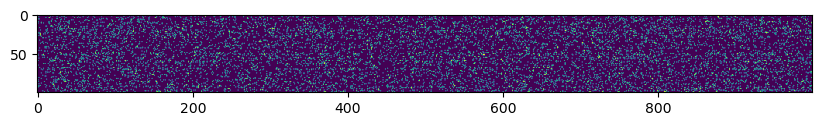

In [3]:
# Timesteps
num_timesteps = 1000

# Network parameters
num_inputs = 100
num_reservoir = 1000
num_readout= 100

# Inputs are just random poisson noise
spike_rates = np.random.uniform(0.05, 0.15, num_inputs)
input_spikes = np.transpose(np.random.binomial(1, spike_rates, size=(num_timesteps, num_inputs)))

# Just for show
plt.figure(figsize=(10,5))
plt.imshow(input_spikes)

In [4]:
## Develop Fugu Scaffold
scaffold = Scaffold()

# Instantiate bricks
input_brick = scaffold.add_brick(Vector_Input(input_spikes, coding='Raster', time_dimension=True, name='input'))
reservoir_brick = scaffold.add_brick(sampled_8020_reservoir(num_reservoir=num_reservoir, num_readout=num_readout, name='reservoir'), output=True)

# Connect the bricks
scaffold.connect(input_brick, reservoir_brick)

# Build the network
scaffold.lay_bricks()

In [5]:
# Get the list of readout neurons for recording
record_neurons = []
for n in range(num_readout):
    record_neurons.append(scaffold.graph.nodes[f"{reservoir_brick.brick_tag}:readout{n}"]['neuron_number'])

In [6]:
## Set up Fugu-STACS backend
backend = stacs_Backend()
backend_args = {}
# set to true to print output from the STACS build process
backend_args['debug_mode'] = True
# ideally, this would be a list of the neuron indexes
# that have the 'record == True' attribute in Fugu
backend_args['record'] = 'all'
# location of charmrun and stacs executable
backend_args['stacsbin'] = '/Users/felwang/stacs'
# location of where to save the network
backend_args['netwkdir'] = './fugunet'
# name of the network files
backend_args['filebase'] = 'fugunet'
# optional event list format (default is Pandas dataframe)
backend_args['format'] = 'eventlist'
# number of files to split the network across for storage
# 1 is probably fine for a single node machine, maybe 2
backend_args['npdat'] = 1
# number of partitions to split the network across
# if using just the default STACS build, this is equivalent to the number of cores
# if using a separate partitioner, it's better to set this to nprun for speed
backend_args['npnet'] = 8
# number of parallel processes to launch STACS with (e.g. num CPUs on the system)
# this number should be less than or equal to the number of partitions
backend_args['nprun'] = 8

## Compile with STACS backend
backend.compile(scaffold, backend_args)

Run command: /Users/felwang/stacs/charmrun +p8 /Users/felwang/stacs/stacs ./fugunet/fugunet.yml
>>> Last relay 1211
>>> first relay: 1204
>>> curr relay: 1203
>>> curr relay: 1204
>>> curr relay: 1205
>>> curr relay: 1206
>>> curr relay: 1207
>>> curr relay: 1208
>>> curr relay: 1209
>>> curr relay: 1210
N NEURONS: 1212
runcmd: /Users/felwang/stacs/charmrun +p8 /Users/felwang/stacs/stacs ./fugunet/fugunet.yml

Running as 8 OS processes:  /Users/felwang/stacs/stacs ./fugunet/fugunet.yml build 
charmrun> mpirun -np 8  /Users/felwang/stacs/stacs ./fugunet/fugunet.yml build 
Charm++> Running on MPI version: 4.1
Charm++> level of thread support used: -1 (desired: 0)
Charm++> Running in non-SMP mode: 8 processes (PEs)
Converse/Charm++ Commit ID: v70000
Charm++ built without optimization.
Do not use for performance benchmarking (build with --with-production to do so).
Charm++ built with internal error checking enabled.
Do not use for performance benchmarking (build without --enable-error-chec

In [7]:
## Running the network in STACS
fuguout_el = backend.run(num_timesteps)


Running as 8 OS processes:  /Users/felwang/stacs/stacs ./fugunet/fugunet.yml simulate 
charmrun> mpirun -np 8  /Users/felwang/stacs/stacs ./fugunet/fugunet.yml simulate 
Charm++> Running on MPI version: 4.1
Charm++> level of thread support used: -1 (desired: 0)
Charm++> Running in non-SMP mode: 8 processes (PEs)
Converse/Charm++ Commit ID: v70000
Charm++ built without optimization.
Do not use for performance benchmarking (build with --with-production to do so).
Charm++ built with internal error checking enabled.
Do not use for performance benchmarking (build without --enable-error-checking to do so).
Isomalloc> Synchronized global address space.
CharmLB> Load balancer assumes all CPUs are same.
Charm++> Running on 1 hosts (1 sockets x 12 cores x 1 PUs = 12-way SMP)
Charm++> cpu topology info is gathered in 0.000 seconds.

Simulation Tool for Asynchronous Cortical Streams (stacs)
Reading config from ./fugunet/fugunet.yml
Reading model information
  Model: 1   Name: spike_input   Type: 

In [8]:
## total number of events
num_events = 0
for neuron_events in fuguout_el:
    num_events += len(neuron_events)
print(num_events)

204109


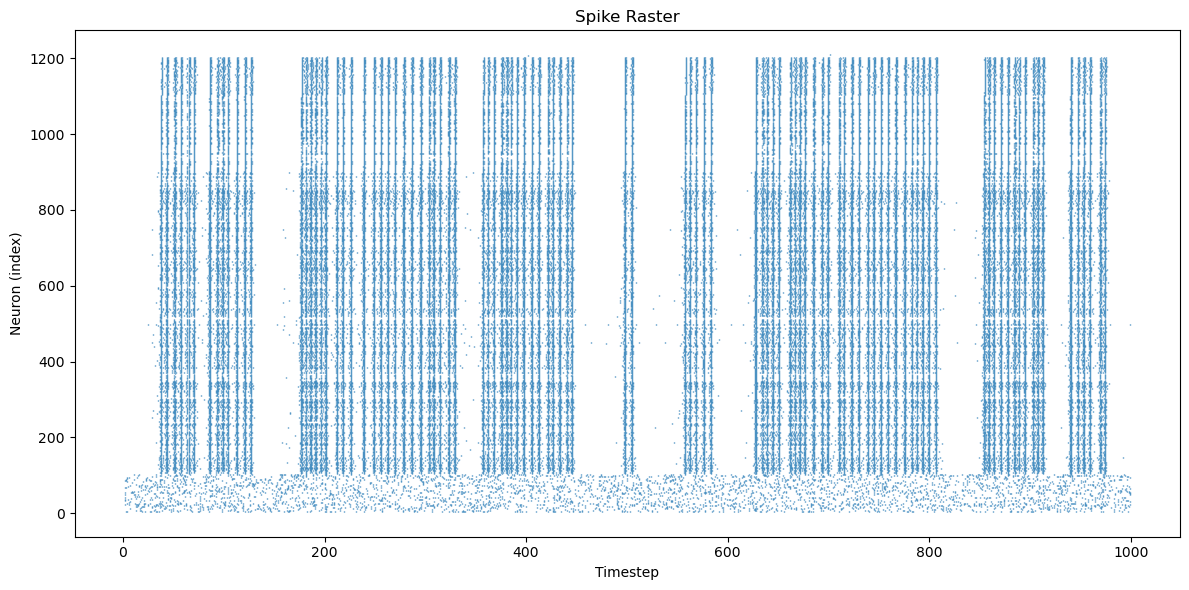

In [9]:
plt.figure(figsize=(12,6))
plt.eventplot(fuguout_el,lineoffsets=1,linelengths=1.0,linewidths=1.0)
plt.title("Spike Raster")
plt.xlabel('Timestep')
plt.ylabel('Neuron (index)')
plt.tight_layout()